In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import HTML
from sklearn import cross_validation
from sklearn import grid_search
from sklearn import preprocessing
from sklearn import metrics
import xgboost as xgb
import datetime

In [2]:
train = pd.read_csv("input/train.csv", parse_dates=["Date"])
test = pd.read_csv("input/test.csv", parse_dates=["Date"])
stores = pd.read_csv("input/store.csv")

/home/deathcoil/anaconda3/envs/python2env/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2902: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## Some data analysis

In [3]:
train[(train["Store"] == 3) & (train["Sales"] != 0)].head(n = 10)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
2,3,5,2015-07-31,8314,821,1,1,0,1
1117,3,4,2015-07-30,8977,823,1,1,0,1
2232,3,3,2015-07-29,7610,716,1,1,0,1
3347,3,2,2015-07-28,8864,818,1,1,0,1
4462,3,1,2015-07-27,8107,768,1,1,0,1
6692,3,6,2015-07-25,3878,412,1,0,0,0
7807,3,5,2015-07-24,5080,607,1,0,0,1
8922,3,4,2015-07-23,5702,655,1,0,0,1
10037,3,3,2015-07-22,5414,607,1,0,0,1
11152,3,2,2015-07-21,5600,661,1,0,0,1


In [4]:
date_nopromo = np.array(train[(train["Store"] == 3) & (train["Sales"] != 0) &
                                 (train["Promo"] == 0)]["Date"])
date_promo = np.array(train[(train["Store"] == 3) & (train["Sales"] != 0) &
                                 ((train["Promo"] != 0) )]["Date"])

In [5]:
sales_nopromo = np.array(train[(train["Store"] == 3) & (train["Sales"] != 0) &
                                 (train["Promo"] == 0)]["Sales"])
sales_promo = np.array(train[(train["Store"] == 3) & (train["Sales"] != 0) &
                                 ((train["Promo"] != 0))]["Sales"])

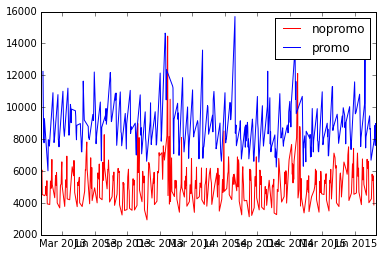

In [6]:
%matplotlib inline
plt.plot(date_nopromo, sales_nopromo, "r", label="nopromo")
plt.plot(date_promo, sales_promo, label="promo")
plt.legend()
plt.show()

In [7]:
print(train.dtypes)

Store                     int64
DayOfWeek                 int64
Date             datetime64[ns]
Sales                     int64
Customers                 int64
Open                      int64
Promo                     int64
StateHoliday             object
SchoolHoliday             int64
dtype: object


In [8]:
print(test.dtypes)

Id                        int64
Store                     int64
DayOfWeek                 int64
Date             datetime64[ns]
Open                    float64
Promo                     int64
StateHoliday             object
SchoolHoliday             int64
dtype: object


## Simple xgboost model

In [9]:
class EnsembleClassifier():
    def __init__(self, **kwargs):

        #seed_list = [1234, 2345, 3456]
        seed_list = [1234]
        clfs = []

        for seed in seed_list:
            temp_params = kwargs
            temp_params["seed"] = seed
            clfs.append(xgb.XGBRegressor(**temp_params))

        self.clfs = clfs

    def fit(self, X, y):
        for clf in self.clfs:
            clf.fit(X, y)
        return self

    def predict(self, X):
        preds = np.zeros(X.shape[0])
        for clf in self.clfs:
            preds += clf.predict(X)

        preds /= len(self.clfs)
        return preds

    def set_params(self, **params):
        for clf in self.clfs:
            clf.set_params(**params)


        return self

    def get_params(self, deep=True):
        return self.clfs[0].get_params(deep=deep)

In [10]:
# byChenglong Chen
def ToWeight(y):
    w = np.zeros(y.shape, dtype=float)
    ind = y != 0
    w[ind] = 1./(y[ind]**2)
    return w


def rmspe(yhat, y):
    y = np.exp(y) - 1
    yhat = np.exp(yhat) - 1
    w = ToWeight(y)
    rmspe = np.sqrt(np.mean( w * (y - yhat)**2 ))
    return rmspe

In [11]:
def load_data():
    train = pd.read_csv("input/train.csv")
    test = pd.read_csv("input/test.csv")
    store = pd.read_csv("input/store.csv")

    return train, test, store

In [12]:
def convert_date(data):
    data['year'] = data["Date"].apply(lambda x: x.split('-')[0]).astype(pd.np.int64)
    data['month'] = data["Date"].apply(lambda x: x.split('-')[1]).astype(pd.np.int64)
    data['day'] = data["Date"].apply(lambda x: x.split('-')[2]).astype(pd.np.int64)

    data["MonthBegins"] = data["day"] < 6
    data["MonthEnds"] = data["day"] > 24

    return data

In [13]:
def preprocess_data(train, test, store):
    test.fillna(1, inplace=True)
    test["Open"] = test["Open"].astype(pd.np.int64)

    train = train[train["Open"] != 0]

    train = pd.merge(train, store, on="Store")
    test = pd.merge(test, store, on="Store")


    sales = train["Sales"]
    index = test["Id"]

    train_test_index = -(train["Date"] < "2015-06-15").astype(pd.np.int32).values
    return train, sales.values.astype("float32"), test, index, train_test_index

In [14]:
def add_counters(train, test):
    #todo: folding
    columns = ["Store", "DayOfWeek", "Promo"]
    means = train.groupby(columns)["Sales"].mean()
    means = means.reset_index()
    means = means.rename(columns={"Sales" : "MeanSales"})

    train = pd.merge(train, means, on=columns, how="left", left_index=True, sort=False)
    test = pd.merge(test, means, on=columns, how="left", left_index=True, sort=False)

    medians = train.groupby(columns)["Sales"].median()
    medians = medians.reset_index()
    medians = medians.rename(columns={"Sales" : "MedianSales"})
    train = pd.merge(train, medians, on=columns, how="left", left_index=True, sort=False)
    test = pd.merge(test, medians, on=columns, how="left", left_index=True, sort=False)

    train = train.drop("Sales", axis=1)

    return train, test

In [15]:
def rework_features(train, test, target):
    le = preprocessing.LabelEncoder()

    le.fit(train["Assortment"])
    train["Assortment"] = le.transform(train["Assortment"])
    test["Assortment"] = le.transform(test["Assortment"])

    le.fit(train["StoreType"])
    train["StoreType"] = le.transform(train["StoreType"])
    test["StoreType"] = le.transform(test["StoreType"])

    train, test = convert_date(train), convert_date(test)

    train, test = add_counters(train, test)

    train.drop(["Customers", "StateHoliday", "Store", "PromoInterval",
                "Date"], axis=1, inplace=True)
    test.drop(["StateHoliday", "Id", "Store", "PromoInterval",
               "Date"], axis=1, inplace=True)

    return train, test

In [16]:
def parametr_tuning(train_x, train_y, train_test_index):
    rmspe_scorer = metrics.make_scorer(rmspe, greater_is_better=False)
    param_grid = {"max_depth" : [5]}

    xgb_model = EnsembleClassifier(n_estimators=500, learning_rate=0.1)

    train_test_split = cross_validation.PredefinedSplit(test_fold=train_test_index)

    clf = grid_search.GridSearchCV(xgb_model, param_grid, scoring=rmspe_scorer,
                                   cv=train_test_split, verbose=10, n_jobs=1)
    clf.fit(train_x.values.astype(np.float32), train_y)

    print("Best score is: ", clf.best_score_)
    print("Best parametrs:")

    best_params = clf.best_estimator_.get_params()
    for param_name in sorted(best_params.keys()):
        print(param_name, ":", best_params[param_name])

    return clf.grid_scores_

In [17]:
def save_result(index, result):
    df = pd.DataFrame({"PostId": index, "OpenStatus": result})
    df.to_csv("output/" + str(datetime.datetime.now()), index=False)

In [18]:
train, test, store = load_data()
X_train, target, X_test, index, train_test_index = preprocess_data(train, test, store)

X_train, X_test = rework_features(X_train, X_test, target)

grid = parametr_tuning(X_train, np.log(target+1), train_test_index)

Fitting 1 folds for each of 1 candidates, totalling 1 fits
[CV] max_depth=5 .....................................................
[CV] ........................... max_depth=5, score=-0.130454 - 5.2min

/home/deathcoil/anaconda3/envs/python2env/lib/python2.7/site-packages/IPython/core/interactiveshell.py:3006: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):
[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:  5.2min



('Best score is: ', -0.13045393028751029)
Best parametrs:
('base_score', ':', 0.5)
('colsample_bylevel', ':', 1)
('colsample_bytree', ':', 1)
('gamma', ':', 0)
('learning_rate', ':', 0.1)
('max_delta_step', ':', 0)
('max_depth', ':', 5)
('min_child_weight', ':', 1)
('missing', ':', None)
('n_estimators', ':', 500)
('nthread', ':', -1)
('objective', ':', 'reg:linear')
('reg_alpha', ':', 0)
('reg_lambda', ':', 1)
('scale_pos_weight', ':', 1)
('seed', ':', 1234)
('silent', ':', True)
('subsample', ':', 1)


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  5.2min finished
